# DkNN - Experiment1: OoD Testsets

<br/>

<pre>
model name:            imagewoof_128_resnet18_model.pth
network architecture:  resnet18
image size:            128x128
test set:              imagenette testset (natural OoD samples)
                       FGSM testset (adversarial OoD samples)
                       BIM testset (adversarial OoD samples)
                       PGD testset (adversarial OoD samples)
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagewoof dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagewoof dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

For comparison we test the DkNN method on the official test set of the [Imagewoof dataset](https://github.com/fastai/imagenette) to see how the method performs on in-distribution samples.

<br/>

_Sources:_
* [Imagewoof dataset](https://github.com/fastai/imagenette)
* [Fetching activations in PyTorch](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html)
* [Deep kNN paper](https://arxiv.org/abs/1803.04765)
* [Deep kNN sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py)
* [Deep kNN sample code (PyTorch)](https://github.com/bam098/deep_knn/blob/master/dknn_mnist.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
from pathlib import Path
import random
import warnings
import pprint
from collections import Counter
import time
import math
import enum
import falconn
import faiss
import copy
from bisect import bisect_left

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
# Data
img_size          = 128                                                             # Image size
num_classes       = 10                                                              # Number of classes
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagewoof')        # Base data folder
fname_string      = 'imagewoof_{}_resnet18'.format(img_size)                        # Dataset folder name
dataloader_path   = base_data_folder/fname_string                                   # Dataloader path

# OoD Data
base_nood_folder  = Path('/Users/lehmann/research/laca3/datasets/imagenette')       # Base data folder
fname_string_nood = 'imagenette_testset_{}'.format(img_size)                        # Dataset folder name
loader_nood_path  = base_nood_folder/fname_string_nood                              # Dataloader path
fname_string_adv  = 'imagewoof_{}_resnet18_model_adv'.format(img_size)              # Adversarial file name
adv_fgsm_path     = base_data_folder/(fname_string_adv+'_fgsm')                     # Adversarial FGSM file path
adv_bim_path      = base_data_folder/(fname_string_adv+'_bim2')                     # Adversarial BIM file path
adv_pgd_path      = base_data_folder/(fname_string_adv+'_pgd')                      # Adversarial PGD file path


# Model
base_model_folder = Path('/Users/lehmann/research/laca3/models/imagewoof')          # Base model folder
mfname_string     = fname_string + '_model'                                         # Model name
model_path        = base_model_folder/mfname_string                                 # Model path
arch              = models.resnet18(pretrained=False)                               # Network architecture

# Activations
# CAUTION --> make sure you chose the correct layers below!

# DkNN
neighbors = 75                                                                      # number of nearest neighbors for DkNN

## Function for Displaying Images

In [4]:
labels = (
    'Samoyed',
    'English foxhound',
    'Old English sheepdog',
    'Rhodesian ridgeback',
    'beagle',
    'Australian terrier',
    'golden retriever',
    'dingo',
    'Shih-Tzu',
    'Border terrier'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
        img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
        img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Load Data

In [5]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [6]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

For our OoD detection method we need a calibration set later. The calibration set should not be drawn from the training distribution. However, we still need their labels. Thus, we split the original test set into two sets. One is used as the calibration set and the other one is used as the new test set for evaluating the model and calculating the credibility scores using our OoD detection method later. According to [Papernot and McDaniel](https://arxiv.org/abs/1803.04765) we chose a calibration set size of 750 samples. When we split the dataset we use the seed value for [reproducibility](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split).

In [7]:
# Create train dataloader
trainloader = torch.load(str(dataloader_path)+'_trainset.pth')

# Create test dataloaders
testloader = torch.load(str(dataloader_path)+'_testset.pth')
testloader_nood = torch.load(str(loader_nood_path)+'.pth')
testloader_fgsm = torch.load(str(adv_fgsm_path)+'.pth')
testloader_bim  = torch.load(str(adv_bim_path)+'.pth')
testloader_pgd  = torch.load(str(adv_pgd_path)+'.pth')

# Create calib dataloader
calibloader = torch.load(str(dataloader_path)+'_calibset.pth')

# Check size of test set
train_size = len(trainloader.dataset)
test_size = len(testloader.dataset)
test_size_nood = len(testloader_nood.dataset)
test_size_fgsm = len(testloader_fgsm.dataset)
test_size_bim = len(testloader_bim.dataset)
test_size_pgd = len(testloader_pgd.dataset)
calib_size = len(calibloader.dataset)

print('trainset size:        {}'.format(train_size))
print('testset size:         {}'.format(test_size))
print('calibset size:        {}'.format(calib_size))
print('testset (NOOD) size:  {}'.format(test_size_nood))
print('testset (FGSM) size:  {}'.format(test_size_fgsm))
print('testset (BIM) size:   {}'.format(test_size_bim))
print('testset (PGD) size:   {}'.format(test_size_pgd))

trainset size:        9025
testset size:         3179
calibset size:        750
testset (NOOD) size:  3925
testset (FGSM) size:  3179
testset (BIM) size:   3179
testset (PGD) size:   3179


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


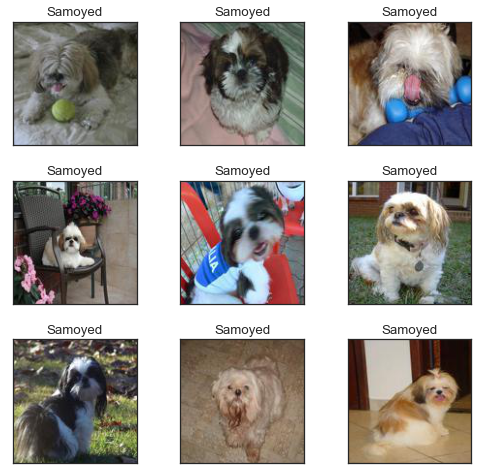

In [8]:
# Display a few train images
train_dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(train_dataiter)

show_samples(train_sample_data, train_sample_targets)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


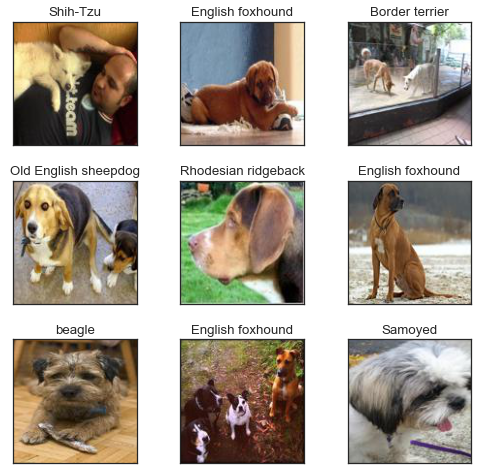

In [9]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets)

tensor shape: (750, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


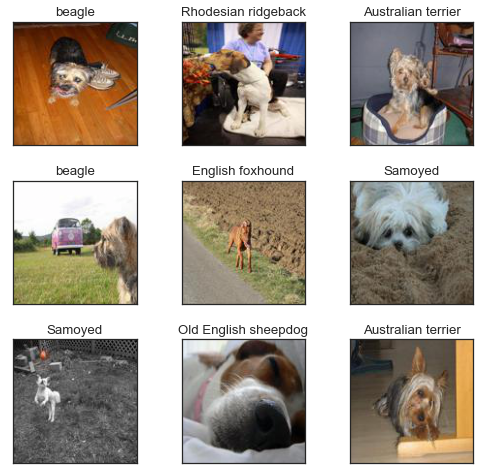

In [10]:
# Display a few calib images
calib_dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(calib_dataiter)

show_samples(calib_sample_data, calib_sample_targets)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


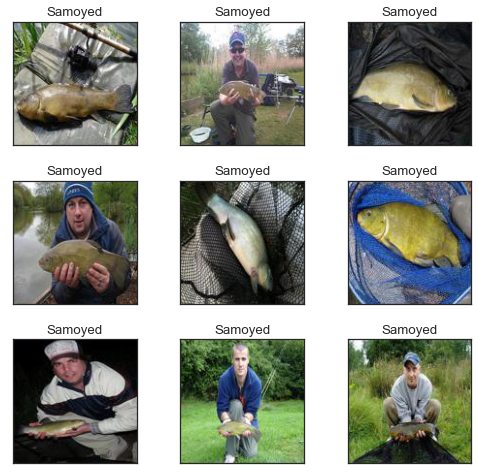

In [11]:
# Display a few test (nood) images
test_dataiter_nood = enumerate(testloader_nood)
_, (test_sample_data_nood, test_sample_targets_nood) = next(test_dataiter_nood)

show_samples(test_sample_data_nood, test_sample_targets_nood)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


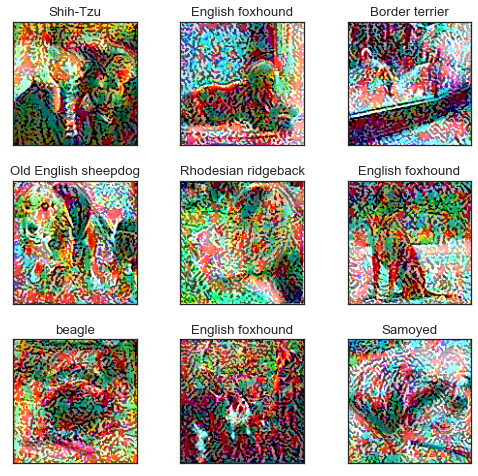

In [12]:
# Display a few test (fgsm) images
test_dataiter_fgsm = enumerate(testloader_fgsm)
_, (test_sample_data_fgsm, test_sample_targets_fgsm) = next(test_dataiter_fgsm)

show_samples(test_sample_data_fgsm, test_sample_targets_fgsm)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


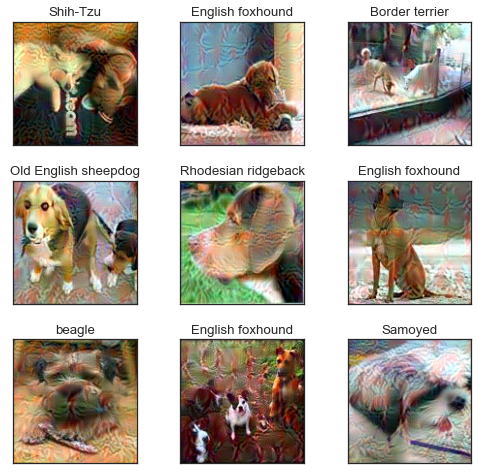

In [13]:
# Display a few test (bim) images
test_dataiter_bim = enumerate(testloader_bim)
_, (test_sample_data_bim, test_sample_targets_bim) = next(test_dataiter_bim)

show_samples(test_sample_data_bim, test_sample_targets_bim)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


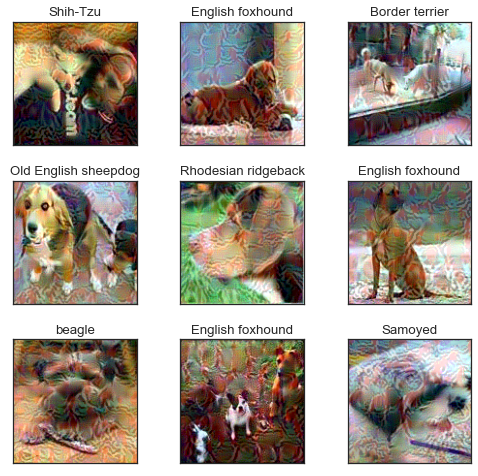

In [14]:
# Display a few test (pgd) images
test_dataiter_pgd = enumerate(testloader_pgd)
_, (test_sample_data_pgd, test_sample_targets_pgd) = next(test_dataiter_pgd)

show_samples(test_sample_data_pgd, test_sample_targets_pgd)

## Prepare Network Architecture

We use the [resnet18](https://arxiv.org/abs/1512.03385) network architecture from the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) (see [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)). However, the architecture was built for the [ImageNet dataset](https://www.image-net.org/). Thus, the architecture has an output size of 1000 which correspond to the 1000 [ImageNet](https://www.image-net.org/) classes. However, [Imagenette](https://github.com/fastai/imagenette) only has 10 classes. Thus, we need to adapt the output layer accordingly.

In [15]:
num_ftrs = arch.fc.in_features
arch.fc = nn.Linear(num_ftrs, num_classes)

print(arch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
model_parameters = filter(lambda p: p.requires_grad, arch.parameters())
params = sum([np.prod(p.size()) for p in model_parameters]); 

print("Number of model parameters: {}".format(params))

Number of model parameters: 11181642


## Define Test Functions

In [17]:
def test(model, criterion, dataloader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(dataloader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

def test_final(model, dataloader, criterion):
    _, accs = test(model, criterion, dataloader, [], [])
    return accs[0]

## Model Testing

In [18]:
# Create Model
model = arch
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load(str(model_path)+'.pth', map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [19]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [20]:
test_acc = test_final(model, testloader, criterion)
test_acc_nood = test_final(model, testloader_nood, criterion)
test_acc_fgsm = test_final(model, testloader_fgsm, criterion)
test_acc_bim = test_final(model, testloader_bim, criterion)
test_acc_pgd = test_final(model, testloader_pgd, criterion)

print('test accuracy:         {}'.format(test_acc))
print('test accuracy (nood):  {}'.format(test_acc_nood))
print('test accuracy (fgsm):  {}'.format(test_acc_fgsm))
print('test accuracy (bim):   {}'.format(test_acc_bim))
print('test accuracy (pgs):   {}'.format(test_acc_pgd))


Test set: Avg. loss: 0.001599, Accuracy: 2385/3179 (75.02%)


Test set: Avg. loss: 0.007200, Accuracy: 490/3925 (12.48%)


Test set: Avg. loss: 0.008074, Accuracy: 387/3179 (12.17%)


Test set: Avg. loss: 0.019267, Accuracy: 76/3179 (2.39%)


Test set: Avg. loss: 0.031949, Accuracy: 3/3179 (0.09%)

test accuracy:         75.02359232463039
test accuracy (nood):  12.48407643312102
test accuracy (fgsm):  12.173639509279647
test accuracy (bim):   2.390688895879207
test accuracy (pgs):   0.09436929852154766


## Set Layers

__Make sure to choose the correct layers here!__

In [21]:
layers = {                                     
    'relu': model.relu,
    'maxpool': model.maxpool,
    'layer1-0': model.layer1[0],
    'layer1-1': model.layer1[1],
    'layer2-0': model.layer2[0],
    'layer2-1': model.layer2[1],
    'layer3-0': model.layer3[0],
    'layer3-1': model.layer3[1],
    'layer4-0': model.layer4[0],
    'layer4-1': model.layer4[1],
    'avgpool': model.avgpool
}

## DkNN Initialization

In [22]:
def get_activations(dataloader, model, layers): 
    activations = {}
    activations['activations'] = {}
    activations['targets'] = []
    
    handlers = {}
    
    # Define hook
    def get_activations(layer_name):
        def hook(model, input, output):            
            layer_activations = output.squeeze().detach().cpu().numpy()

            if len(layer_activations.shape) == 4:
                layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)
        
            activations['activations'][layer_name].append(layer_activations)
            
        return hook
    
    # Register Hooks
    print('## Registering Hooks')
    
    for layer_name in layers:
        print('Register Hook for Layer {}'.format(layer_name))
        activations['activations'][layer_name] = []
        handlers[layer_name] = layers[layer_name].register_forward_hook(get_activations(layer_name))
    
    print()
        
    # Fetch activations
    print('## Fetching Activations')
    targets = []
    
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()
            
        _ = model(batch[0])

        if len(batch) > 1:
            activations['targets'].append(batch[1].detach().cpu().numpy())
            
    print('- activations fetched')
    print()
     
    # Concetenate batch activations/targets and remove hooks
    print('## Removing Hooks')
    activations['targets'] = np.concatenate(activations['targets'])
    
    for layer_name in layers:
        print('Remove Hook from Layer {}'.format(layer_name))
        activations['activations'][layer_name] = np.concatenate(activations['activations'][layer_name])
        handlers[layer_name].remove()
        
    print()
    print("done!")        
    print()
        
    return activations


class NearestNeighbor:

    class BACKEND(enum.Enum):
        FALCONN = 1
        FAISS = 2

    def __init__(self, backend, dimension, neighbors, number_bits, nb_tables=None):
        assert backend in NearestNeighbor.BACKEND

        self._NEIGHBORS = neighbors
        self._BACKEND = backend

        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._init_falconn(dimension, number_bits, nb_tables)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._init_faiss(dimension)
        else:
            raise NotImplementedError

    def _init_falconn(self, dimension, number_bits, nb_tables):
        assert nb_tables >= self._NEIGHBORS

        # LSH parameters
        params_cp = falconn.LSHConstructionParameters()
        params_cp.dimension = dimension
        params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
        params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
        params_cp.l = nb_tables
        params_cp.num_rotations = 2  # for dense set it to 1; for sparse data set it to 2
        params_cp.seed = 5721840
        params_cp.num_setup_threads = 0  # we want to use all the available threads to set up
        params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable

        # we build number_bits-bit hashes so that each table has
        # 2^number_bits bins; a rule of thumb is to have the number
        # of bins be the same order of magnitude as the number of data points
        falconn.compute_number_of_hash_functions(number_bits, params_cp)
        self._falconn_table = falconn.LSHIndex(params_cp)
        self._falconn_query_object = None
        self._FALCONN_NB_TABLES = nb_tables

    def _init_faiss(self, dimension):
        res = faiss.StandardGpuResources()
        self._faiss_index = faiss.GpuIndexFlatL2(res, dimension)

    def add(self, x):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._falconn_table.setup(x)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._faiss_index.add(x)
        else:
            raise NotImplementedError

    def find_knns(self, x, output):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            return self._find_knns_falconn(x, output)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            return self._find_knns_faiss(x, output)
        else:
            raise NotImplementedError

    def _find_knns_falconn(self, x, output):
        # Late falconn query_object construction
        # Since I suppose there might be an error
        # if table.setup() will be called after
        if self._falconn_query_object is None:
            self._falconn_query_object = self._falconn_table.construct_query_object()
            self._falconn_query_object.set_num_probes(self._FALCONN_NB_TABLES)

        missing_indices = np.zeros(output.shape, dtype=np.bool)

        for i in range(x.shape[0]):
            query_res = self._falconn_query_object.find_k_nearest_neighbors(x[i], self._NEIGHBORS)

            try:
                output[i, :] = query_res
            except:
                # mark missing indices
                missing_indices[i, len(query_res):] = True
                output[i, :len(query_res)] = query_res

        return missing_indices

    def _find_knns_faiss(self, x, output):
        neighbor_distance, neighbor_index = self._faiss_index.search(x, self._NEIGHBORS)

        missing_indices = neighbor_distance == -1
        d1 = neighbor_index.reshape(-1)

        output.reshape(-1)[np.logical_not(missing_indices.flatten())] = d1[np.logical_not(missing_indices.flatten())]

        return missing_indices


class DkNN:

    def __init__(self, model, nb_classes, neighbors, layers, trainloader, nearest_neighbor_backend, nb_tables=200, number_bits=17):
        """
        Implementation of the DkNN algorithm, see https://arxiv.org/abs/1803.04765 for more details
        :param model: model to be used
        :param nb_classes: the number of classes in the task
        :param neighbors: number of neighbors to find per layer
        :param layers: a list of layer names to include in the DkNN
        :param trainloader: data loader for the training data
        :param nearest_neighbor_backend: falconn or faiss to be used for LSH
        :param nb_tables: number of tables used by FALCONN to perform locality-sensitive hashing.
        :param number_bits: number of hash bits used by LSH.
        """
        print('---------- DkNN init')
        print()

        self.model = model
        self.nb_classes = nb_classes
        self.neighbors = neighbors
        self.layers = layers
        self.backend = nearest_neighbor_backend
        self.nb_tables = nb_tables
        self.number_bits = number_bits

        self.nb_cali = -1
        self.calibrated = False   

        # Compute training data activations
        activations = get_activations(trainloader, model, layers)
        self.train_activations = activations['activations']
        self.train_labels = activations['targets']

        # Build locality-sensitive hashing tables for training representations
        self.train_activations_lsh = copy.copy(self.train_activations)
        self.init_lsh()

    def init_lsh(self):
        """
        Initializes locality-sensitive hashing with FALCONN to find nearest neighbors in training data
        """
        self.query_objects = {} # contains the object that can be queried to find nearest neighbors at each layer
        self.centers = {} # mean of training data representation per layer (that needs to be substracted before NearestNeighbor)

        print("## Constructing the NearestNeighbor tables")

        for layer in self.layers:
            print("Constructing table for {}".format(layer))

            # Normalize all the lenghts, since we care about the cosine similarity
            self.train_activations_lsh[layer] /= np.linalg.norm(self.train_activations_lsh[layer], axis=1).reshape(-1, 1)

            # Center the dataset and the queries: this improves the performance of LSH quite a bit
            center = np.mean(self.train_activations_lsh[layer], axis=0)
            self.train_activations_lsh[layer] -= center
            self.centers[layer] = center

            # Constructing nearest neighbor table
            self.query_objects[layer] = NearestNeighbor(
                backend=self.backend,
                dimension=self.train_activations_lsh[layer].shape[1],
                number_bits=self.number_bits,
                neighbors=self.neighbors,
                nb_tables=self.nb_tables,
            )

            self.query_objects[layer].add(self.train_activations_lsh[layer])

        print("done!")
        print()


    def calibrate(self, calibloader):
        """
        Runs the DkNN on holdout data to calibrate the credibility metric
        :param calibloader: data loader for the calibration loader
        """
        print('---------- DkNN calibrate')
        print()

        # Compute calibration data activations
        self.nb_cali = len(calibloader.dataset)
        activations = get_activations(calibloader, self.model, self.layers)
        self.cali_activations = activations['activations']
        self.cali_labels = activations['targets']

        print("## Starting calibration of DkNN")

        cali_knns_ind, cali_knns_labels = self.find_train_knns(self.cali_activations)
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_ind.values()])
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_labels.values()])

        cali_knns_not_in_class = self.nonconformity(cali_knns_labels)
        cali_knns_not_in_l = np.zeros(self.nb_cali, dtype=np.int32)

        for i in range(self.nb_cali):
            cali_knns_not_in_l[i] = cali_knns_not_in_class[i, self.cali_labels[i]]

        cali_knns_not_in_l_sorted = np.sort(cali_knns_not_in_l)
        self.cali_nonconformity = np.trim_zeros(cali_knns_not_in_l_sorted, trim='f')
        self.nb_cali = self.cali_nonconformity.shape[0]
        self.calibrated = True

        print("DkNN calibration complete")

    def find_train_knns(self, data_activations):
        """
        Given a data_activation dictionary that contains a np array with activations for each layer,
        find the knns in the training data
        """
        knns_ind = {}
        knns_labels = {}

        for layer in self.layers:
            # Pre-process representations of data to normalize and remove training data mean
            data_activations_layer = copy.copy(data_activations[layer])
            nb_data = data_activations_layer.shape[0]
            data_activations_layer /= np.linalg.norm(data_activations_layer, axis=1).reshape(-1, 1)
            data_activations_layer -= self.centers[layer]

            # Use FALCONN to find indices of nearest neighbors in training data
            knns_ind[layer] = np.zeros((data_activations_layer.shape[0], self.neighbors), dtype=np.int32)
            knn_errors = 0

            knn_missing_indices = self.query_objects[layer].find_knns(data_activations_layer, knns_ind[layer])
            knn_errors += knn_missing_indices.flatten().sum()

            # Find labels of neighbors found in the training data
            knns_labels[layer] = np.zeros((nb_data, self.neighbors), dtype=np.int32)

            knns_labels[layer].reshape(-1)[
                np.logical_not(knn_missing_indices.flatten())
            ] = self.train_labels[
                knns_ind[layer].reshape(-1)[np.logical_not(knn_missing_indices.flatten())]                    
            ]

        return knns_ind, knns_labels

    def nonconformity(self, knns_labels):
        """
        Given an dictionary of nb_data x nb_classes dimension, compute the nonconformity of
        each candidate label for each data point: i.e. the number of knns whose label is
        different from the candidate label
        """
        nb_data = knns_labels[list(self.layers.keys())[0]].shape[0]
        knns_not_in_class = np.zeros((nb_data, self.nb_classes), dtype=np.int32)

        for i in range(nb_data):
            # Compute number of nearest neighbors per class
            knns_in_class = np.zeros((len(self.layers), self.nb_classes), dtype=np.int32)

            for layer_id, layer in enumerate(self.layers):
                knns_in_class[layer_id, :] = np.bincount(knns_labels[layer][i], minlength=self.nb_classes)

            # Compute number of knns in other class than class_id
            for class_id in range(self.nb_classes):
                knns_not_in_class[i, class_id] = np.sum(knns_in_class) - np.sum(knns_in_class[:, class_id])

        return knns_not_in_class

    def fprop(self, testloader):
        """
        Performs a forward pass through the DkNN on an numpy array of data
        """
        print('---------- DkNN predict')
        print()

        if not self.calibrated:
            raise ValueError("DkNN needs to be calibrated by calling DkNNModel.calibrate method once before inferring")

        # Compute test data activations
        activations = get_activations(testloader, self.model, self.layers)
        data_activations = activations['activations']
        
        start_time = time.time()
        _, knns_labels = self.find_train_knns(data_activations)
        end_time = time.time()
        
        print('kNN search time: {}'.format(end_time - start_time))

        # Calculate nonconformity
        knns_not_in_class = self.nonconformity(knns_labels)
        print('Nonconformity calculated')

        # Create predictions, confidence and credibility
        _, _, creds = self.preds_conf_cred(knns_not_in_class)
        print('Predictions created')

        return creds, activations['targets']

    def preds_conf_cred(self, knns_not_in_class):
        """
        Given an array of nb_data x nb_classes dimensions, use conformal prediction to compute
        the DkNN's prediction, confidence and credibility
        """
        nb_data = knns_not_in_class.shape[0]
        preds_knn = np.zeros(nb_data, dtype=np.int32)
        confs = np.zeros((nb_data, self.nb_classes), dtype=np.float32)
        creds = np.zeros((nb_data, self.nb_classes), dtype=np.float32)

        for i in range(nb_data):
            # p-value of test input for each class
            p_value = np.zeros(self.nb_classes, dtype=np.float32)

            for class_id in range(self.nb_classes):
                # p-value of (test point, candidate label)
                p_value[class_id] = (float(self.nb_cali) - bisect_left(self.cali_nonconformity, knns_not_in_class[i, class_id])) / float(self.nb_cali)

            preds_knn[i] = np.argmax(p_value)
            confs[i, preds_knn[i]] = 1. - np.sort(p_value)[-2]
            creds[i, preds_knn[i]] = p_value[preds_knn[i]]

        return preds_knn, confs, creds


def plot_reliability_diagram(confidence, labels):
    """
    Takes in confidence values (e.g. output of softmax or DkNN confidences) for
    predictions and correct labels for the data, plots a reliability diagram
    :param confidence: nb_samples x nb_classes with confidence scores
    :param labels: targets
    """
    assert len(confidence.shape) == 2
    assert len(labels.shape) == 1
    assert confidence.shape[0] == labels.shape[0]

    if confidence.max() <= 1.:
        # confidence array is output of softmax
        bins_start = [b / 10. for b in range(0, 10)]
        bins_end = [b / 10. for b in range(1, 11)]
        bins_center = [(b + .5) / 10. for b in range(0, 10)]
        preds_conf = np.max(confidence, axis=1)
        preds_l = np.argmax(confidence, axis=1)
    else:
        raise ValueError('Confidence values go above 1')

    print(preds_conf.shape, preds_l.shape)

    # Create var for reliability diagram (Will contain mean accuracies for each bin)
    reliability_diag = []
    num_points = []  # keeps the number of points in each bar

    # Find average accuracy per confidence bin
    for bin_start, bin_end in zip(bins_start, bins_end):
        above = preds_conf >= bin_start

        if bin_end == 1.:
            below = preds_conf <= bin_end
        else:
            below = preds_conf < bin_end

        mask = np.multiply(above, below)
        num_points.append(np.sum(mask))

        bin_mean_acc = max(0, np.mean(preds_l[mask] == labels[mask]))
        reliability_diag.append(bin_mean_acc)

    # Plot diagram
    assert len(reliability_diag) == len(bins_center)
    #print(reliability_diag)
    #print(bins_center)
    #print(num_points)

    fig, ax1 = plt.subplots()
    _ = ax1.bar(bins_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    plt.xlim([0, 1.])
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()

    #print(sum(num_points))

    ax2.plot(bins_center, num_points, color='r', linestyle='-', linewidth=7.0)
    ax2.set_ylabel('Number of points in the data', fontsize=16, color='r')

    if len(np.argwhere(confidence[0] != 0.)) == 1:
        # This is a DkNN diagram
        ax1.set_xlabel('Prediction Credibility', fontsize=16)
    else:
        # This is a softmax diagram
        ax1.set_xlabel('Prediction Confidence', fontsize=16)

    ax1.set_ylabel('Prediction Accuracy', fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14, colors='r')
    fig.tight_layout()
    plt.show()

In [23]:
# Initialize DkNN
dknn = DkNN(model, num_classes, neighbors, layers, trainloader, NearestNeighbor.BACKEND.FALCONN)

---------- DkNN init

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpoo

In [24]:
dknn.calibrate(calibloader)

---------- DkNN calibrate

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!

## Starting calibration of DkNN
DkNN calibration complete


## Get Testset Credibility

### Testset

In [25]:
start_credib = time.time()

dknn_preds_testset, test_targets = dknn.fprop(testloader)

end_credib = time.time()

---------- DkNN predict

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!

kNN search time: 1867.4774940013885
Nonconformity calculated
Predictions created


In [26]:
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset.shape))
print('targets: {}'.format(test_targets.shape))

---------------------------------------------
preds:   (3179, 10)
targets: (3179,)


In [27]:
test_credibs = list(np.max(dknn_preds_testset, axis=1))

In [28]:
num_samples = len(test_credibs)
total_credib = np.sum(np.array(test_credibs)) / num_samples
print(total_credib)

0.9012489954830528


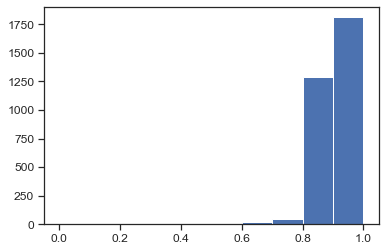

In [29]:
plt.hist(test_credibs, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

(3179,) (3179,)


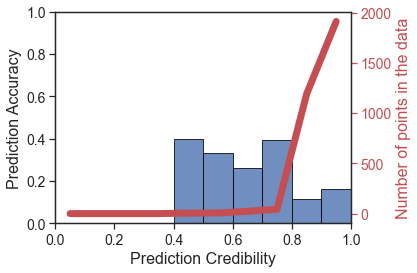

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset, test_targets)

In [31]:
time_total = end_credib - start_credib
print('total: {}'.format(time_total))

total: 1955.507348060608


### NOOD

In [32]:
start_credib_nood = time.time()

dknn_preds_testset_nood, test_targets_nood = dknn.fprop(testloader_nood)

end_credib_nood = time.time()

---------- DkNN predict

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!

kNN search time: 2252.60639500618
Nonconformity calculated
Predictions created


In [33]:
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset_nood.shape))
print('targets: {}'.format(test_targets_nood.shape))

---------------------------------------------
preds:   (3925, 10)
targets: (3925,)


In [34]:
test_credibs_nood = list(np.max(dknn_preds_testset_nood, axis=1))

In [35]:
num_samples_nood = len(test_credibs_nood)
total_credib_nood = np.sum(np.array(test_credibs_nood)) / num_samples_nood
print(total_credib_nood)

0.905219508857484


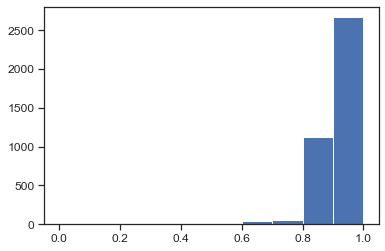

In [36]:
plt.hist(test_credibs_nood, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

(3925,) (3925,)


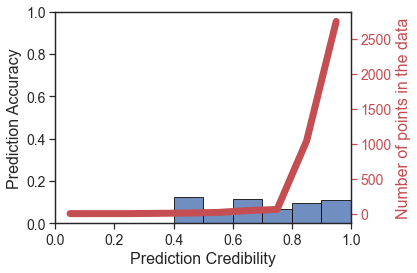

In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset_nood, test_targets_nood)

In [38]:
time_total_nood = end_credib_nood - start_credib_nood
print('total: {}'.format(time_total_nood))

total: 2368.1802258491516


### FGSM

In [39]:
start_credib_fgsm = time.time()

dknn_preds_testset_fgsm, test_targets_fgsm = dknn.fprop(testloader_fgsm)

end_credib_fgsm = time.time()

---------- DkNN predict

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!

kNN search time: 1869.8385937213898
Nonconformity calculated
Predictions created


In [40]:
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset_fgsm.shape))
print('targets: {}'.format(test_targets_fgsm.shape))

---------------------------------------------
preds:   (3179, 10)
targets: (3179,)


In [41]:
test_credibs_fgsm = list(np.max(dknn_preds_testset_fgsm, axis=1))

In [42]:
num_samples_fgsm = len(test_credibs_fgsm)
total_credib_fgsm = np.sum(np.array(test_credibs_fgsm)) / num_samples_fgsm
print(total_credib_fgsm)

0.9242835367352155


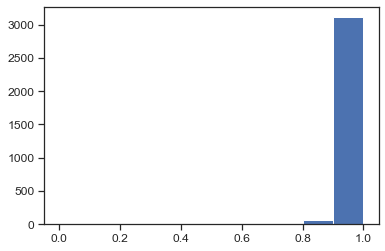

In [43]:
plt.hist(test_credibs_fgsm, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

(3179,) (3179,)


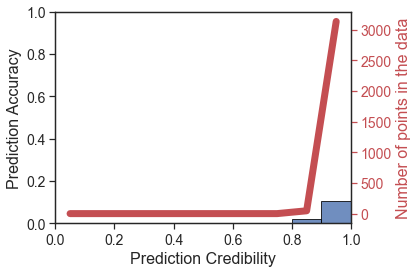

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset_fgsm, test_targets_fgsm)

In [45]:
time_total_fgsm = end_credib_fgsm - start_credib_fgsm
print('total: {}'.format(time_total_fgsm))

total: 1960.102531194687


### BIM

In [46]:
start_credib_bim = time.time()

dknn_preds_testset_bim, test_targets_bim = dknn.fprop(testloader_bim)

end_credib_bim = time.time()

---------- DkNN predict

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!

kNN search time: 1901.7958867549896
Nonconformity calculated
Predictions created


In [47]:
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset_bim.shape))
print('targets: {}'.format(test_targets_bim.shape))

---------------------------------------------
preds:   (3179, 10)
targets: (3179,)


In [48]:
test_credibs_bim = list(np.max(dknn_preds_testset_bim, axis=1))

In [49]:
num_samples_bim = len(test_credibs_bim)
total_credib_bim = np.sum(np.array(test_credibs_bim)) / num_samples_bim
print(total_credib_bim)

0.9122239575141554


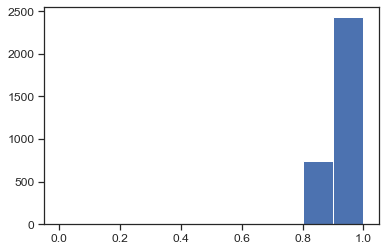

In [50]:
plt.hist(test_credibs_bim, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

(3179,) (3179,)


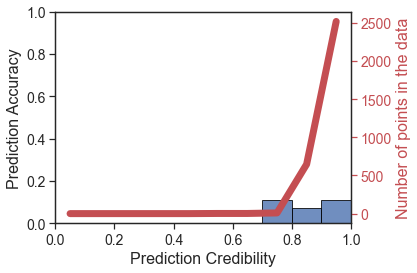

In [51]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset_bim, test_targets_bim)

In [52]:
time_total_bim = end_credib_bim - start_credib_bim
print('total: {}'.format(time_total_bim))

total: 1989.6625590324402


### PGD

In [53]:
start_credib_pgd = time.time()

dknn_preds_testset_pgd, test_targets_pgd = dknn.fprop(testloader_pgd)

end_credib_pgd = time.time()

---------- DkNN predict

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!

kNN search time: 1881.7596440315247
Nonconformity calculated
Predictions created


In [54]:
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset_pgd.shape))
print('targets: {}'.format(test_targets_pgd.shape))

---------------------------------------------
preds:   (3179, 10)
targets: (3179,)


In [55]:
test_credibs_pgd = list(np.max(dknn_preds_testset_pgd, axis=1))

In [56]:
num_samples_pgd = len(test_credibs_pgd)
total_credib_pgd = np.sum(np.array(test_credibs_pgd)) / num_samples_pgd
print(total_credib_pgd)

0.9106658042770919


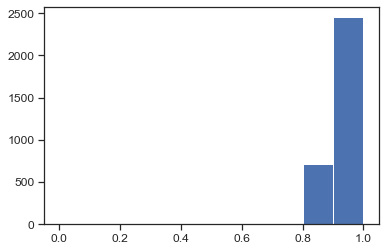

In [57]:
plt.hist(test_credibs_pgd, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

(3179,) (3179,)


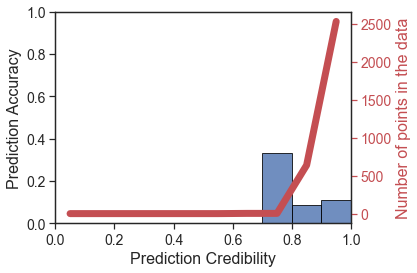

In [58]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset_pgd, test_targets_pgd)

In [59]:
time_total_pgd = end_credib_pgd - start_credib_pgd
print('total: {}'.format(time_total_pgd))

total: 1970.1738550662994
